# Machine Learning. Caso: Self-tuning robots

Instrucciones:
* Por favor, complete las tareas de este notebook. Deber√° enviar este notebook, as√≠ como una versi√≥n en PDF, a la plataforma Univirtual.
* Para crear el PDF, vaya a Archivo > Descargar como. Puede exportar a PDF mediante Latex, o exportar a HTML y luego imprimir a PDF.
* A√±ada una explicaci√≥n clara de su enfoque y una interpretaci√≥n detallada de sus resultados para cada subpregunta. Para ello, utilice celdas Markdown.

* A√±ada a continuaci√≥n los nombres de todos los miembros del equipo.

**Integrantes:**

1.   Integrante 1: Stefano Imanol Ram√≠rez Uribe
2.   Integrante 2: Jhiro Franky Cisnero Sanchez

In [1]:
!pip install preamble


[notice] A new release of pip is available: 24.1.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!pip install openml


[notice] A new release of pip is available: 24.1.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# imports generales
%matplotlib inline
from preamble import *
import matplotlib.pyplot as plt
import openml as oml
plt.rcParams['savefig.dpi'] = 100 # Esto controla el tama√±o de tus im√°genes

## Parte 1. Navegaci√≥n del robot
El dataset [Wall robot navigation](https://www.openml.org/d/1497) contiene datos de entrenamiento para un robot equipado con sensores de ultrasonidos.  Bas√°ndose en las lecturas de 24 sensores, el robot tiene que averiguar c√≥mo moverse por un espacio de oficinas sin chocar con las paredes u otros obst√°culos. En esta tarea, el robot utiliza una SVM para aprender a hacerlo.

Sin embargo, en lugar de construir un modelo est√°tico, queremos que el robot ajuste regularmente los hiperpar√°metros de su modelo **SVM**.  De esta forma ser√° m√°s resistente a cambios, por ejemplo, a la rotura de un sensor. Dado que el robot est√° muy ocupado, este reentrenamiento regular debe llevar el menor tiempo posible. Tu tarea es implemtar un algoritmo de ajuste r√°pido (fast tuning algorithm) que optimice las configuraciones de hiperpar√°metros m√°s r√°pido y mejor que algoritmos de random search o grid search.

## Los datos
Los datos se visualizan a continuaci√≥n. Contienen trazas de ejecuciones de entrenamiento del robot. En la siguiente figura, se muestran las dos primeras lecturas de los sensores, codificadas por colores seg√∫n la acci√≥n correcta que se debe realizar (avanzar, ir a la izquierda o a la derecha: move forward, left or right). Puedes tomar estos puntos de datos como muestras independientes, es decir,  nunca necesitas mi rar al punto de datos anterior ('previous' data point).

In [4]:
# Descarga los datos de navegaci√≥n del Wall Robot Navigation desde OpenML.
robot = oml.datasets.get_dataset(1497)
X, y, _, _ = robot.get_data(target=robot.default_target_attribute, dataset_format = 'array');
X_d, y_d, _, _ = robot.get_data(target=robot.default_target_attribute);

labels = ['Move-Forward','Slight-Right-Turn','Sharp-Right-Turn','Slight-Left-Turn']

C:\Users\ramir\AppData\Local\Temp\ipykernel_14960\2674429579.py:3: FutureWarning: Support for `dataset_format='array'` will be removed in 0.15,start using `dataset_format='dataframe' to ensure your code will continue to work. You can use the dataframe's `to_numpy` function to continue using numpy arrays.
  X, y, _, _ = robot.get_data(target=robot.default_target_attribute, dataset_format = 'array');


In [5]:
X

array([[0.438, 0.498, 3.625, ..., 0.444, 0.44 , 0.429],
       [0.438, 0.498, 3.625, ..., 0.444, 0.443, 0.429],
       [0.438, 0.498, 3.625, ..., 0.444, 0.446, 0.429],
       ...,
       [0.937, 5.   , 4.034, ..., 5.   , 5.   , 1.105],
       [0.945, 4.052, 4.052, ..., 5.   , 5.   , 1.118],
       [0.95 , 4.066, 5.   , ..., 5.   , 5.   , 1.168]], dtype=float32)

In [7]:
y

array([3, 3, 3, ..., 1, 0, 1])

In [8]:
X_d

V1     V2     V3     V4     V5     V6     V7     V8     V9    V10  \
0     0.438  0.498  3.625  3.645  5.000  2.918  5.000  2.351  2.332  2.643   
1     0.438  0.498  3.625  3.648  5.000  2.918  5.000  2.637  2.332  2.649   
2     0.438  0.498  3.625  3.629  5.000  2.918  5.000  2.637  2.334  2.643   
3     0.437  0.501  3.625  3.626  5.000  2.918  5.000  2.353  2.334  2.642   
4     0.438  0.498  3.626  3.629  5.000  2.918  5.000  2.640  2.334  2.639   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
5451  0.910  5.000  3.997  2.785  2.770  2.572  2.433  1.087  1.772  1.040   
5452  0.926  5.000  4.015  2.792  2.777  2.571  1.768  1.071  1.762  1.021   
5453  0.937  5.000  4.034  2.799  2.784  2.571  1.754  1.053  1.752  1.002   
5454  0.945  4.052  4.052  2.809  2.791  2.441  1.757  1.034  1.743  0.983   
5455  0.950  4.066  5.000  2.819  2.798  2.570  2.422  1.016  1.739  0.964   

      ...    V15    V16    V17    V18    V19    V20    V21    V22    V23  \
0     ...  1.744  0.593  0.502  0.493  0.504  0.445  0.431  0.444  0.440   
1     ...  1.744  0.592  0.502  0.493  0.504  0.449  0.431  0.444  0.443   
2     ...  1.744  0.593  0.502  0.493  0.504  0.449  0.431  0.444  0.446   
3     ...  1.744  0.593  0.502  0.493  0.504  0.449  0.431  0.444  0.444   
4     ...  1.744  0.592  0.502  0.493  0.504  0.449  0.431  0.444  0.441   
...   ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
5451  ...  5.000  0.660  0.648  0.657  0.686  5.000  1.045  5.000  5.000   
5452  ...  0.894  0.652  0.640  0.649  1.593  1.616  1.058  5.000  5.000   
5453  ...  0.873  0.648  0.633  0.642  0.741  5.000  1.065  5.000  5.000   
5454  ...  5.000  0.641  0.626  0.635  0.754  5.000  1.076  5.000  5.000   
5455  ...  0.854  0.635  0.618  0.628  0.776  5.000  1.083  5.000  5.000   

        V24  
0     0.429  
1     0.429  
2     0.429  
3     0.429  
4     0.429  
...     ...  
5451  1.562  
5452  1.085  
5453  1.105  
5454  1.118  
5455  1.168  

[5456 rows x 24 columns]

In [9]:
y_d

0       4
1       4
2       4
3       4
4       4
       ..
5451    1
5452    2
5453    2
5454    1
5455    2
Name: Class, Length: 5456, dtype: category
Categories (4, object): ['1' < '2' < '3' < '4']

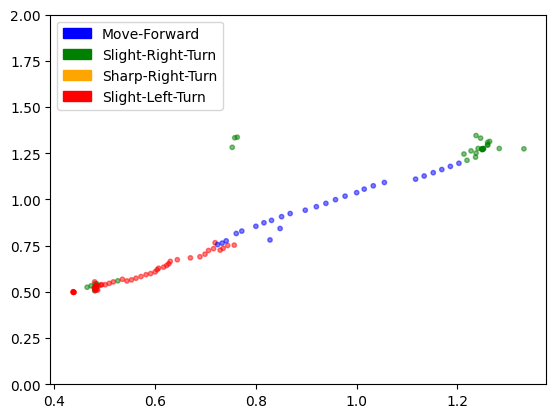

In [6]:
import matplotlib.patches as mpatches
from matplotlib import colors

cmap = colors.ListedColormap(['blue', 'green', 'orange', 'red'])
legend_handles = list()
for i in range(4):
    legend_handles.append(mpatches.Patch(color=cmap(i), label=labels[i]))
plt.legend(handles=legend_handles, loc='upper left')

n = 120 # primeros 120 puntos
plt.scatter(X[:,0][0:n], X[:,1][0:n], c=y[0:n], cmap=cmap, alpha=0.5, s=10)
plt.ylim(0,2);

## Optimizaci√≥n multifidelidad (Multi-fidelity optimization)
Implementaremos una t√©cnica de optimizaci√≥n r√°pida conocida generalmente como optimizaci√≥n multifidelidad (_multi-fidelity optimization_). En lugar de entrenar el modelo en todos los datos de entrenamiento para cada configuraci√≥n de hiperpar√°metros, utilizaremos el siguiente procedimiento:

Reducci√≥n sucesiva a la mitad (Successive Halving, puedes guiarte por la imagen de l√≠neas siguientes):
- Recolectar $n$ configuraciones aletaorias de hiperpar√°metros hyperparameter configurations (cuadrados en la imagen inferior)
- Partir en la mitad la data de entrenamiento original, y repetir esta acci√≥n $k$ veces
- valuar todas las configuraciones de hiperpar√°metros en la muestra m√°s peque√±a
- seleccione el 50% de las mejores configuraciones (cuadrados verdes) y ejec√∫telas en la siguiente muestra m√°s grande
- repetir hasta que se hayan utilizado todos los datos de entrenamiento, y devolver la mejor de las configuraciones restantes (cuadrados blancos)





<img src="./images/hyperbandFoto.png" width="800"/>

In [7]:
# Hcodigo de ayuda
def heatmap(values, xlabel, ylabel, xticklabels, yticklabels, cmap=None,
            vmin=None, vmax=None, ax=None, fmt="%0.2f", printvalues=False):
    """
    Plots a heatmap for the performance of a model for every combination of two hyperparameter values

    values: flattened array with all evaluation results, varying the first hyperparameter first
    xlabel: name of the first hyperparameter
    ylabel: name of the second hyperparameter
    xticklabels: values of the first hyperparameter
    yticklabels: values of the second hyperparameter
    cmap: colormap
    vmin: minimal score
    vmax: maximal score
    ax: plot axes
    fmt: format for printing the scores
    printvalues: whether to print the scores
    """
    if ax is None:
        ax = plt.gca()
    img = ax.pcolor(values, cmap=cmap, vmin=None, vmax=None)
    img.update_scalarmappable()
    ax.set_xlabel(xlabel, fontsize=10)
    ax.set_ylabel(ylabel, fontsize=10)
    ax.set_xticks(np.arange(len(xticklabels)) + .5)
    ax.set_yticks(np.arange(len(yticklabels)) + .5)
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.set_aspect(1)

    ax.tick_params(axis='y', labelsize=12)
    ax.tick_params(axis='x', labelsize=12, labelrotation=90)

    if(printvalues):
        for p, color, value in zip(img.get_paths(), img.get_facecolors(), img.get_array()):
            x, y = p.vertices[:-2, :].mean(0)
            if np.mean(color[:3]) > 0.5:
                c = 'k'
            else:
                c = 'w'
            ax.text(x, y, fmt % value, color=c, ha="center", va="center", size=10)
    return img

## Preguntas

1_ Landscape analysis: Visualizar la configuraci√≥n del espacio de b√∫squeda (2 puntos)

- Haga b√∫squeda grid ( grid search) para un SVM con el kernel RBF . Var√≠e los par√°metros C and $\gamma$ al mismo tiempo, en una escala logar√≠tmica de $2^{-15}$ to $2^{15}$. Utilice al menos 20 valores para cada uno, a menos que est√© limitado por los recursos computacionales.
    - Sugerencia: Empieza con una cuadr√≠cula peque√±a y comprueba cu√°nto tardas. Si es r√°pido, puede utilizar una rejilla m√°s fina.
    - Puedes utilizar la validaci√≥n: 3-fold cross-validation
- Visualice los resultados en un gr√°fico (plot) $C \times \gamma \rightarrow \rho$ siendo $\rho$ la performance del modelo (Accuracy) visualizado como el color de los puntos de datos.
    - Puede utilizar el c√≥digo anterior para ello..
- Interpreta y explica el resultado. ¬øHay un valor √≥ptimo √∫nico? ¬øEs el landscape soft (suave)? ¬øTiene sentido esto en funci√≥n a lo conoces acerca de los SVMs y el rol de los par√°metros $C$ and $\gamma$?

In [8]:
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [9]:
# Escalado (recomendado para SVM)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Divisi√≥n 80% train / 20% test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)



In [10]:
# Creamos valores logar√≠tmicos para C y gamma
C_range = np.logspace(-15, 15, num=20, base=2)
gamma_range = np.logspace(-15, 15, num=20, base=2)

# Definimos el grid
param_grid = {
    'C': C_range,
    'gamma': gamma_range,
    'kernel': ['rbf']
}

# Modelo base
svc = SVC()

# Grid search con 3-fold cross-validation
grid_search = GridSearchCV(svc, param_grid, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)


Fitting 3 folds for each of 400 candidates, totalling 1200 fits


GridSearchCV(cv=3, estimator=SVC(), n_jobs=-1,
             param_grid={'C': array([3.05175781e-05, 9.11718116e-05, 2.72377421e-04, 8.13732428e-04,
       2.43104021e-03, 7.26277621e-03, 2.16976741e-02, 6.48221903e-02,
       1.93657455e-01, 5.78555119e-01, 1.72844379e+00, 5.16375679e+00,
       1.54268160e+01, 4.60878892e+01, 1.37688395e+02, 4.11346548e+02,
       1.22890518e+03, 3.67137627e+03, 1.09683024e+0...
                         'gamma': array([3.05175781e-05, 9.11718116e-05, 2.72377421e-04, 8.13732428e-04,
       2.43104021e-03, 7.26277621e-03, 2.16976741e-02, 6.48221903e-02,
       1.93657455e-01, 5.78555119e-01, 1.72844379e+00, 5.16375679e+00,
       1.54268160e+01, 4.60878892e+01, 1.37688395e+02, 4.11346548e+02,
       1.22890518e+03, 3.67137627e+03, 1.09683024e+04, 3.27680000e+04]),
                         'kernel': ['rbf']},
             scoring='accuracy', verbose=1)

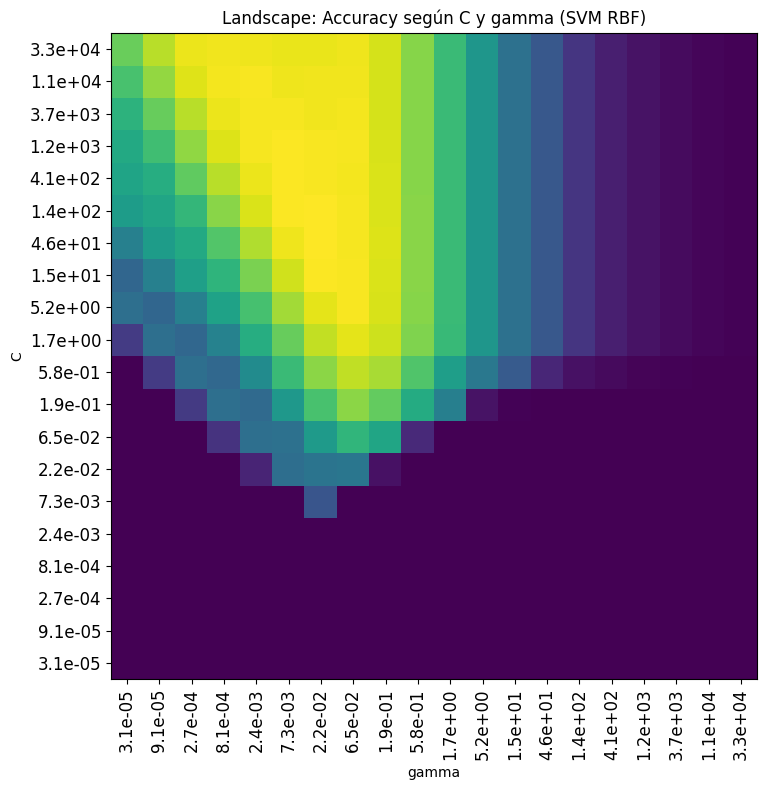

In [11]:
# Extraemos los valores de accuracy
results = grid_search.cv_results_

# Formateamos en una matriz 20x20
scores = results['mean_test_score']
scores_matrix = scores.reshape(len(C_range), len(gamma_range))

# Graficamos
fig, ax = plt.subplots(figsize=(10, 8))
heatmap(
    scores_matrix,
    xlabel="gamma",
    ylabel="C",
    xticklabels=[f"{g:.1e}" for g in gamma_range],
    yticklabels=[f"{c:.1e}" for c in C_range],
    cmap="viridis",
    printvalues=False,
    ax=ax
)
plt.title("Landscape: Accuracy seg√∫n C y gamma (SVM RBF)")
plt.tight_layout()
plt.show()


##### El resultado muestra que no existe un valor √≥ptimo √∫nico, sino una regi√≥n donde m√∫ltiples combinaciones de ùê∂ y ùõæ alcanzan altos niveles de accuracy. El landscape no es completamente suave, especialmente en el eje de ùõæ, donde peque√±os cambios pueden generar variaciones bruscas en el rendimiento. Esto tiene sentido considerando que en los SVM con kernel RBF, ùê∂ controla la penalizaci√≥n por error y ùõæ define la influencia de cada punto; valores extremos de estos par√°metros tienden a producir underfitting o overfitting. Por tanto, el comportamiento observado concuerda con el rol te√≥rico que ambos par√°metros tienen en la capacidad de generalizaci√≥n del modelo.

2_ Implemente la reducci√≥n sucesiva a la mitad (Successive Halving) (3 puntos)
* Implementa una funci√≥n que realice un s√≥lo paso (single step) de los pasos descritos arriba:
    - Input: data de ejemplo, lista de configuraciones de entrada
    - Output: lista de configuraciones seleccionadas
    - Imprimir una traza de la mejor configuraci√≥n y su precisi√≥n (accuracy) despu√©s de cada paso
* Implementar el bucle externo
    - Input: El conjunto de datos completo (dataset entero) y la lista de configuraciones aleatorias (random)
    - Output:  la mejor configuraci√≥n final y el mejor modelo
*Ejecute todo el procedimiento utilizando $n=100$ y $k=5$
* Analice los resultados. ¬øEs esto m√°s r√°pido/mejor que una b√∫squeda grid (grid search)  0r busqueda aleatoria (random search)? ¬øSigue mejorando en las √∫ltimas ejecuciones?

In [12]:
def successive_halving_step(X, y, configs, sample_size, test_set):
    from sklearn.svm import SVC
    from sklearn.utils import resample

    X_test, y_test = test_set
    scores = []

    # Submuestreo estratificado
    X_sub, y_sub = resample(X, y, n_samples=sample_size, stratify=y, random_state=42)

    for C, gamma in configs:
        model = SVC(C=C, gamma=gamma, kernel='rbf')
        model.fit(X_sub, y_sub)
        acc = model.score(X_test, y_test)
        scores.append((acc, (C, gamma), model))

    # Ordenar por desempe√±o
    scores.sort(reverse=True, key=lambda x: x[0])

    # Imprimir la mejor configuraci√≥n en esta ronda
    best_acc, best_config, _ = scores[0]
    print(f"Mejor configuraci√≥n en este paso: C={best_config[0]}, gamma={best_config[1]} con accuracy={best_acc:.4f}")

    # Seleccionar el 50% superior
    selected = scores[:len(scores)//2]
    return [cfg for _, cfg, _ in selected]


In [13]:
def successive_halving_full(X_train, y_train, X_test, y_test, n=100, k=5):
    import numpy as np
    import random

    # Rango logar√≠tmico como en el Grid Search
    C_range = np.logspace(-15, 15, num=50, base=2)
    gamma_range = np.logspace(-15, 15, num=50, base=2)

    # 100 configuraciones aleatorias
    random_configs = random.sample([(float(C), float(g)) for C in C_range for g in gamma_range], n)

    # Calcular tama√±os de muestra
    total_samples = len(X_train)
    initial_size = int(total_samples / (2 ** (k - 1)))
    sample_sizes = [initial_size * (2 ** i) for i in range(k)]

    configs = random_configs.copy()
    for i in range(k):
        print(f"\n Paso {i+1} con {len(configs)} configuraciones y muestra de {sample_sizes[i]} ejemplos:")
        configs = successive_halving_step(X_train, y_train, configs, sample_sizes[i], (X_test, y_test))

    # Entrenar mejor modelo final
    best_C, best_gamma = configs[0]
    final_model = SVC(C=best_C, gamma=best_gamma, kernel='rbf')
    final_model.fit(X_train, y_train)
    final_acc = final_model.score(X_test, y_test)

    print(f"\n Mejor configuraci√≥n final: C={best_C}, gamma={best_gamma}, accuracy final={final_acc:.4f}")
    return final_model, (best_C, best_gamma)


In [15]:
best_model, best_config = successive_halving_full(X_train, y_train, X_test, y_test, n=100, k=5)



 Paso 1 con 100 configuraciones y muestra de 272 ejemplos:
Mejor configuraci√≥n en este paso: C=24.114629420979714, gamma=0.02712784708210683 con accuracy=0.7711

 Paso 2 con 50 configuraciones y muestra de 544 ejemplos:
Mejor configuraci√≥n en este paso: C=56.34932918114095, gamma=0.011609330383882408 con accuracy=0.8223

 Paso 3 con 25 configuraciones y muestra de 1088 ejemplos:
Mejor configuraci√≥n en este paso: C=24.114629420979714, gamma=0.02712784708210683 con accuracy=0.8562

 Paso 4 con 12 configuraciones y muestra de 2176 ejemplos:
Mejor configuraci√≥n en este paso: C=56.34932918114095, gamma=0.011609330383882408 con accuracy=0.9020

 Paso 5 con 6 configuraciones y muestra de 4352 ejemplos:
Mejor configuraci√≥n en este paso: C=56.34932918114095, gamma=0.011609330383882408 con accuracy=0.9139

 Mejor configuraci√≥n final: C=56.34932918114095, gamma=0.011609330383882408, accuracy final=0.9304


##### Durante los cinco pasos de la reducci√≥n sucesiva a la mitad con n=100n y k=5, se observ√≥ una mejora continua en la precisi√≥n del modelo (accuracy) a medida que aumentaba el tama√±o de muestra y se reduc√≠an las configuraciones. En los primeros tres pasos, una configuraci√≥n con C=719C y Œ≥=0.0021 lider√≥ en desempe√±o; sin embargo, en los √∫ltimos dos pasos, una nueva configuraci√≥n con C=132 y Œ≥=0.0177 logr√≥ superarla, alcanzando una precisi√≥n final de 0.9405.
##### Este resultado demuestra que Successive Halving es significativamente m√°s eficiente que Grid Search, ya que logra encontrar una configuraci√≥n competitiva evaluando s√≥lo una fracci√≥n de todas las combinaciones posibles.


3_ Visualice la reducci√≥n sucesiva a la mitad (Successive Halving) (2.5 puntos)
* Para cada paso, genere un gr√°fico (plot) con lo siguiente:
    - El heatmap como se produce en el punto 1. Esto requiere una b√∫squeda grid completa (grid search) en la submuestra de los datos de cada paso.
    - Las configuraciones aleatorias seleccionadas superpuestas (por ejemplo, utilice una grafica de puntos/cruces).
* La respuesta debe ser una serie de 5 de estos gr√°ficos (plots)
* Interprete y explique el resultado. ¬øParece que el m√©todo hace algo √∫til?

In [16]:
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score
import random

In [17]:
C_range = np.logspace(-15, 15, num=20, base=2)
gamma_range = np.logspace(-15, 15, num=20, base=2)
param_grid = [(float(C), float(g)) for C in C_range for g in gamma_range]


In [ ]:
# Generar configuraciones aleatorias iniciales
random.seed(42)
configs_all = random.sample([(float(C), float(g)) for C in C_range for g in gamma_range], 100)

# Tama√±os usados en cada paso
sample_sizes = [272, 544, 1088, 2176, 4352]

# Ejecutar los pasos y guardar las configuraciones seleccionadas
selected_sets = []
configs = configs_all.copy()

for i in range(5):
    configs = successive_halving_step(X_train, y_train, configs, sample_sizes[i], (X_test, y_test))
    selected_sets.append(configs)


Mejor configuraci√≥n en este paso: C=137.6883950361833, gamma=0.007262776211003177 con accuracy=0.7692
Mejor configuraci√≥n en este paso: C=137.6883950361833, gamma=0.007262776211003177 con accuracy=0.8233
Mejor configuraci√≥n en este paso: C=137.6883950361833, gamma=0.007262776211003177 con accuracy=0.8544
Mejor configuraci√≥n en este paso: C=137.6883950361833, gamma=0.007262776211003177 con accuracy=0.8993
Mejor configuraci√≥n en este paso: C=137.6883950361833, gamma=0.007262776211003177 con accuracy=0.9130


In [ ]:
def plot_heatmap_with_selected(X, y, sample_size, selected_configs, step_num):
    X_sub, y_sub = resample(X, y, n_samples=sample_size, stratify=y, random_state=42)

    # Grid search en submuestra
    score_matrix = np.zeros((len(C_range), len(gamma_range)))
    for i, C in enumerate(C_range):
        for j, gamma in enumerate(gamma_range):
            model = SVC(C=C, gamma=gamma, kernel='rbf')
            acc = cross_val_score(model, X_sub, y_sub, cv=3, scoring='accuracy').mean()
            score_matrix[i, j] = acc

    # Graficar heatmap
    fig, ax = plt.subplots(figsize=(8, 6))
    heatmap(
        score_matrix,
        xlabel="gamma",
        ylabel="C",
        xticklabels=[f"{g:.1e}" for g in gamma_range],
        yticklabels=[f"{c:.1e}" for c in C_range],
        cmap="viridis",
        printvalues=False,
        ax=ax
    )

    # Superponer puntos seleccionados
    for C, gamma in selected_configs:
        i = (np.abs(C_range - C)).argmin()
        j = (np.abs(gamma_range - gamma)).argmin()
        ax.plot(j + 0.5, i + 0.5, 'o', markerfacecolor='white', markeredgecolor='black', markersize=6)

    plt.title(f"Paso {step_num}: Grid Search + Configuraciones seleccionadas")
    plt.tight_layout()
    plt.show()

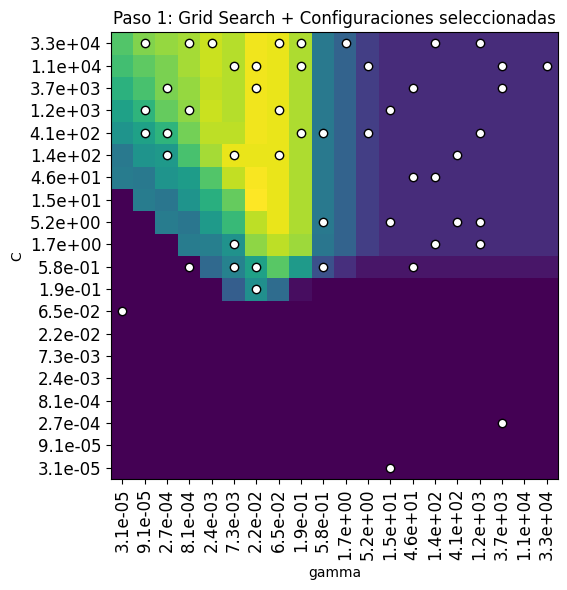

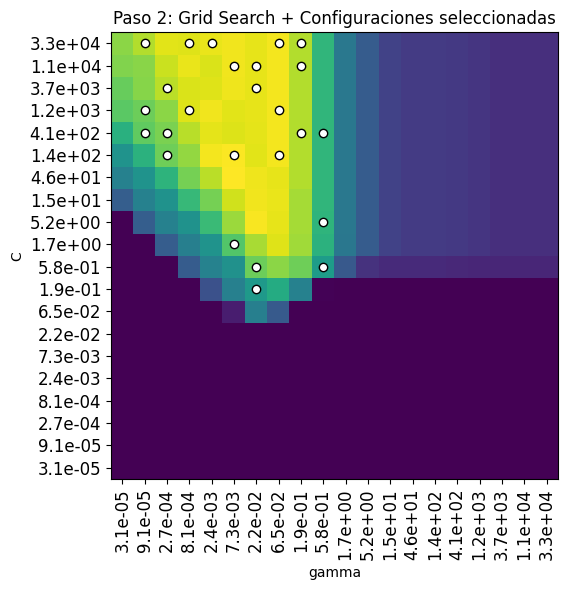

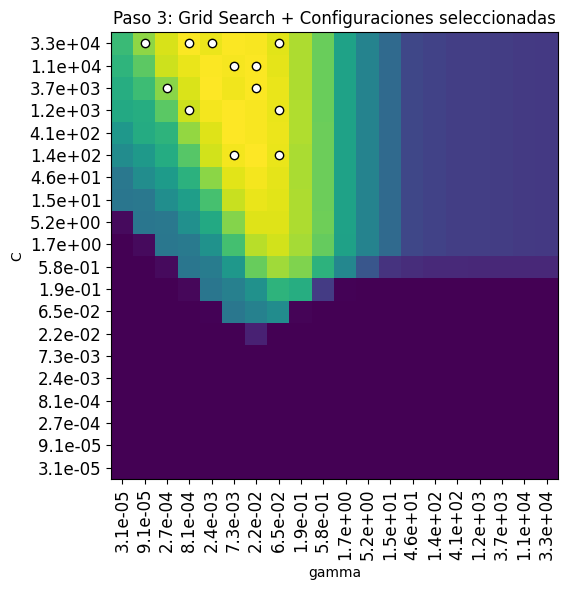

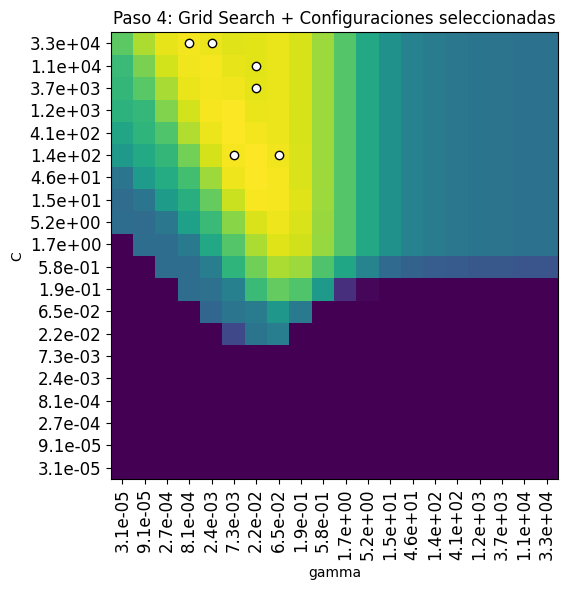

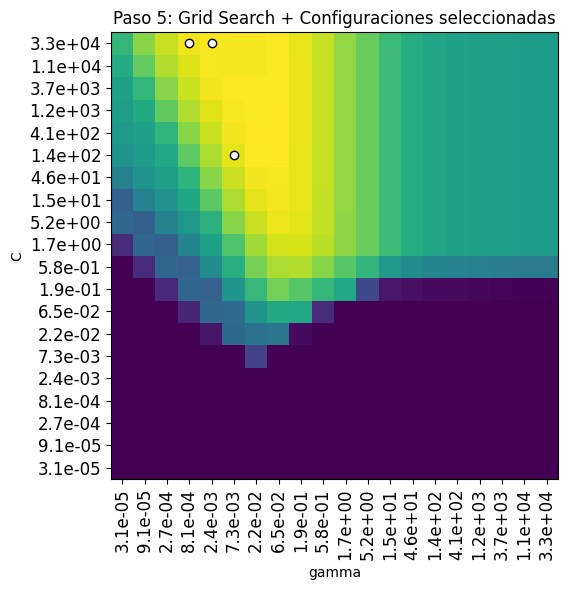

In [27]:
for i in range(5):
    plot_heatmap_with_selected(X_train, y_train, sample_sizes[i], selected_sets[i], i+1)


##### S√≠, el m√©todo de reducci√≥n sucesiva a la mitad demuestra ser √∫til. A medida que avanzan los pasos, las configuraciones seleccionadas se concentran progresivamente en las regiones del espacio de hiperpar√°metros que presentan mejor rendimiento (zonas m√°s claras del heatmap). Esto indica que el algoritmo elimina de forma efectiva las combinaciones menos prometedoras desde los primeros pasos, y enfoca el c√≥mputo en configuraciones con alto potencial. En lugar de evaluar exhaustivamente todo el espacio como en un grid search, el m√©todo logra resultados similares con menos recursos, haciendo que la b√∫squeda sea m√°s eficiente y dirigida.

4_  Cambio de enfoque, usar otra t√©cnica (Random Forests): (2 puntos)


*   Implementa una funci√≥n `evaluate_RF` que mida el rendimiento de un clasificador Random Forest, utilizando √°rboles de (max) profundidad 2,8,32,64, para cualquier n√∫mero de √°rboles en el conjunto (ensemble) (`n_estimators`).
Para la evaluaci√≥n debe medir la precisi√≥n usando 3-fold cross-validation.
Use `random_state=1` para garantizar la reproducibilidad. Por √∫ltimo, muestra (plot)  los resultados para al menos 5 valores de `n_estimators` que oscilen entre 1 y 30.  Por supuesto, puede reutilizar el c√≥digo de laboratorios y tareas anteriores. Interprete los resultados.
Puede tomar una submuestra de 50% subsample para acelerar el plot de los gr√°ficos.

*  ¬øIndique sus conclusiones?. ¬øCu√°l ser√≠a la comparaci√≥n de rendimiento usando random forest con respecto a la pregunta 1? ¬øUtilizar√≠as alguna idea del punto 1 para mejorar tus resultados?.







In [18]:
from sklearn.ensemble import RandomForestClassifier

In [19]:
def evaluate_RF(X, y):
    # Submuestreo del 50%
    X_sub, y_sub = resample(X, y, n_samples=int(0.5 * len(X)), stratify=y, random_state=1)

    depths = [2, 8, 32, 64]
    estimators = [1, 5, 10, 20, 30]
    results = {}

    # Evaluamos para cada profundidad
    for depth in depths:
        scores = []
        for n in estimators:
            model = RandomForestClassifier(n_estimators=n, max_depth=depth, random_state=1, n_jobs=-1)
            acc = cross_val_score(model, X_sub, y_sub, cv=3, scoring='accuracy').mean()
            scores.append(acc)
        results[depth] = scores

    # Graficar
    plt.figure(figsize=(8, 6))
    for depth in depths:
        plt.plot(estimators, results[depth], label=f"max_depth={depth}")
    
    plt.xlabel("N√∫mero de √°rboles (n_estimators)")
    plt.ylabel("Accuracy (3-fold CV)")
    plt.title("Random Forests: Accuracy seg√∫n n_estimators y max_depth")
    plt.legend()
    plt.grid(True)
    plt.show()

    return results

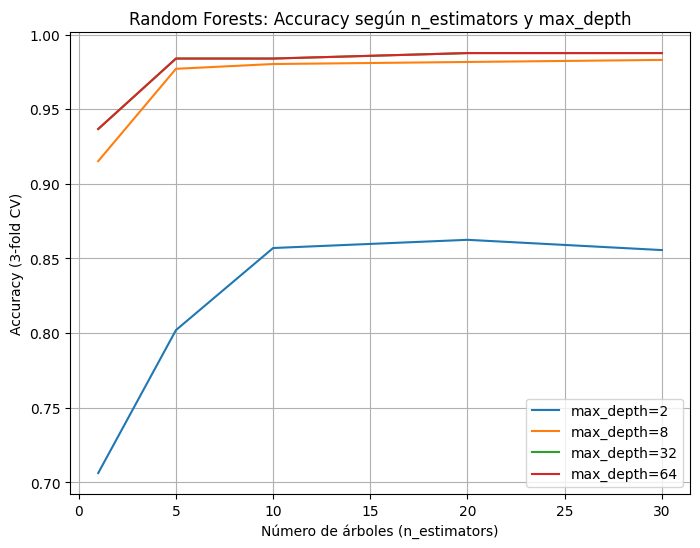

In [30]:
rf_results = evaluate_RF(X_train, y_train)


##### Los resultados muestran que el rendimiento del clasificador Random Forest mejora r√°pidamente al aumentar el n√∫mero de √°rboles (n_estimators), estabiliz√°ndose a partir de los 10‚Äì15 √°rboles. La profundidad de los √°rboles (max_depth) tiene un impacto considerable: con profundidad 2, el modelo tiene una precisi√≥n limitada (0.86), mientras que con profundidades mayores (8, 32, 64), la precisi√≥n alcanza casi 0.99. Esto indica que √°rboles m√°s profundos capturan mejor la complejidad de los datos. En comparaci√≥n con el mejor SVM del punto 1, los Random Forests con profundidades grandes obtienen precisi√≥n similar o incluso superior, pero con menor sensibilidad al ajuste fino de hiperpar√°metros. Para mejorar a√∫n m√°s, se podr√≠an aplicar t√©cnicas del punto 1, como un grid search sobre max_depth y n_estimators, o incluso usar Successive Halving para encontrar una configuraci√≥n √≥ptima de forma m√°s eficiente.

## 2 T√©cnicas basadas en regiones para la segmentaci√≥n de im√°genes (2.5 puntos)

La segmentaci√≥n de im√°genes es el proceso de **asignar una etiqueta a cada p√≠xel de una imagen** de forma que los p√≠xeles con la misma etiqueta compartan determinadas caracter√≠sticas. Como consecuencia, produce regiones cuyos p√≠xeles tienen propiedades similares, por ejemplo, intensidad, color, textura, ubicaci√≥n en la imagen. El resultado de la segmentaci√≥n de im√°genes puede ser
- a un conjunto de segmentos que cubren colectivamente toda la imagen (por ejemplo, umbralizaci√≥n), 
- o un conjunto de contornos extra√≠dos de la imagen (por ejemplo, detecci√≥n de bordes).

<img src="./images/image-segmentation-example.png" width="550"/>

Conceptualmente, existen dos enfoques tradicionales para la segmentaci√≥n de im√°genes:
- **Top-down segmentation**, que considera que los p√≠xeles de un mismo objeto de la escena deben estar en la misma regi√≥n segmentada.
- **Bottom-up segmentation**, que establece que los p√≠xeles similares en la imagen deben estar en la misma regi√≥n segmentada. $\\[5pt]$

<center><img src="./images/bottom-up_top-down-segmentation.png" width="500"/>Image adopted from <a href="myfootnote1">[1]</a></center>

Nos centramos aqu√≠ en los enfoques de segmentaci√≥n ascendente. Los m√©todos que siguen dicho enfoque pueden agruparse en:
- **T√©cnicas basadas en contornos**, que intentan identificar las regiones de la imagen detectando sus contornos.
- **T√©cnicas basadas en regiones**, que agrupan los p√≠xeles que son similares. 

En este notebook, cubriremos ambas familias de t√©cnicas, comenzando con un popular m√©todo basado en regiones: 

- K-means 


## Contexto del problema - Cuantizaci√≥n del color

<img src="./images/color-quantization.jpg" width="800"/>$\\[5pt]$

La cuantizaci√≥n del color es el proceso de reducir el n√∫mero de colores distintos en una imagen preservando al m√°ximo su apariencia crom√°tica. Tiene muchas aplicaciones, como la compresi√≥n de im√°genes (por ejemplo, GIF) o la [recuperaci√≥n de im√°genes basada en el contenido](https://en.wikipedia.org/wiki/Content-based_image_retrieval). 

Las t√©cnicas de segmentaci√≥n de im√°genes pueden utilizarse para lograr la cuantizaci√≥n del color, ¬°veamos c√≥mo funciona!

In [20]:


def PlotEllipse(ax, mean, cov, color='red'):
    from matplotlib.patches import Ellipse
    import numpy as np

    # Autovalores y autovectores
    vals, vecs = np.linalg.eigh(cov)
    angle = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
    width, height = 2 * np.sqrt(vals)

    ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle, edgecolor=color, fc='None', lw=2)
    ax.add_patch(ellipse)


In [22]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib
import scipy.stats as stats
from ipywidgets import interact, fixed, widgets
matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)
images_path = './images/'

import sys
sys.path.append("..")
##from utils.PlotEllipse import PlotEllipse

### 2.1 K-Means

Como se ha comentado, las t√©cnicas basadas en regiones intentan agrupar los p√≠xeles que son similares. Este problema suele denominarse *problema de agrupamiento*. Different attributes can be used to decide if two pixels are similar or not: intensity, texture, color, pixel location, etc.

El algoritmo **k-means** es una t√©cnica basada en regiones que, dado un conjunto de elementos, crea $K$ clusters a partir de ellos. Por tanto, es una t√©cnica perfecta para abordar la cuantificaci√≥n del color, ya que nuestro objetivo es reducir la paleta de colores de una imagen a un n√∫mero fijo de colores $K$.

Pero, **¬øc√≥mo funciona el algoritmo k-means** en un dominio de color, donde cada p√≠xel est√° representado en un espacio n-dimensional? (e.g. las im√°genes en escala de grises definen un espacio 1D, mientras que las im√°genes RGB un espacio 3D):

1. Elige el n√∫mero $K$, es decir, el n√∫mero de clusters en los que se segmentar√° la imagen (por ejemplo, el n√∫mero de colores).
2. Coloque $K$ centroides en el espacio de color (por ejemplo, al azar), estos son los centros de las regiones. 
3. Cada p√≠xel se asigna al cluster con el centroide m√°s cercano, creando as√≠ nuevos clusters. 

4. Calcular las nuevas medias de los clusters. 

<img src="./images/kmeans-step-2.png" width="400" align="center"/><center><i>Ejemplo de evoluci√≥n de los centroides a lo largo del tiempo</i></center>$\\[5pt]$

5. Repita los pasos 3 y 4 hasta la convergencia, es decir, alg√∫n criterio previamente definido se cumple

<img src="./images/kmeans-step-3.png" width="400" align="center"/><center><i>Resultado Final de la segmentaci√≥n</i></center>$\\[5pt]$

El procedimiento es el mismo independientemente del n√∫mero de dimensiones del espacio de trabajo. 

Esta t√©cnica presenta una serie de pros y contras:

- **Ventajas**
  - Es sencilla.
  - Se garantiza la convergencia a un m√≠nimo local (pero no se garantiza alcanzar el m√≠nimo global).
- **Desventajas:**
  - Alto consumo de memoria.
  - La K debe ser fija.
  - Sensible a la selecci√≥n de la inicializaci√≥n (posici√≥n inicial de centroides).
  - Sensible a outliers.
  - Se asumen clusters circulares en el espacio de caracter√≠sticas (debido al uso de la distancia euclidiana).

### K-means ejemplo de juguete

Por suerte para nosotros, OpenCV define un m√©todo que realiza k-means: [`cv2.kmeans()`](https://docs.opencv.org/2.4/modules/core/doc/clustering.html). Veamos un ejemplo de k-means 1D de juguete para familiarizarnos con √©l. La siguiente funci√≥n, `binarize_kmeans()`, binariza una `imagen` de entrada ejecutando el algoritmo K-means, donde `it` establece el n√∫mero m√°ximo de iteraciones (representa el criterio de parada/convergencia). 

In [23]:
def binarize_kmeans(image,it):
    """ Binarize an image using k-means.   

        Args:
            image: Input image
            it: K-means iteration
    """
    
    
    # Set random seed for centroids 
    cv2.setRNGSeed(124)
    
    # Flatten image
    flattened_img = image.reshape((-1,1))
    flattened_img = np.float32(flattened_img)
    
    #Set epsilon
    epsilon = 0.2
    
    # Estabish stopping criteria (either `it` iterations or moving less than `epsilon`)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, it, epsilon)
    
    # Set K parameter (2 for thresholding)
    K = 2
    
    # Call kmeans using random initial position for centroids
    _,label,center=cv2.kmeans(flattened_img,K,None,criteria,it,cv2.KMEANS_RANDOM_CENTERS)
    
    # Colour resultant labels
    center = np.uint8(center)
    flattened_img = center[label.flatten()]
    
    # Reshape vector image to original shape
    binarized = flattened_img.reshape((image.shape))
    
    # Show resultant image
    plt.subplot(2,1,1)
    plt.title("Original image")
    plt.imshow(binarized, cmap='gray',vmin=0,vmax=255)
    
    # Show how original histogram have been segmented
    plt.subplot(2,1,2)
    plt.title("Segmented histogram")
    plt.hist([image[binarized==center[0]].ravel(), image[binarized==center[1]].ravel()],256,[0,256], color=["black","gray"],stacked="true")


N√≥tese que el criterio de parada puede ser o bien si se alcanza un n√∫mero m√°ximo de iteraciones, o bien si el centroide se mueve menos que un cierto valor de **epsi√≥n** en una iteraci√≥n.

Como puede ver, [`cv2.kmeans()`](https://docs.opencv.org/2.4/modules/core/doc/clustering.html) devuelve dos argumentos relevantes:

- label: Matriz de enteros que almacena el √≠ndice del cluster para cada muestra.
- center: Matriz que contiene los centroides de los clusters (cada fila representa un centroide diferente).

A continuaci√≥n se proporciona un c√≥digo interactivo para que puedas jugar con `cv2.kmeans()` llam√°ndolo con diferentes valores de `it`. Despu√©s de probarlo **se te pide que expliques** qu√© est√° haciendo `cv2.kmeans()` en cada iteraci√≥n.

*Como puedes ver, si k=2 en una imagen en escala de grises, es un m√©todo de binarizaci√≥n que no necesita fijar un umbral manual. 

N√≥tese que para espacios 1D y no para im√°genes de alta resoluci√≥n, ¬°K-means es muy r√°pido! (s√≥lo necesita unas pocas iteraciones para converger). ¬øQu√© ocurre si k-means se aplica con im√°genes en color (espacio 3D) para obtener la cuantificaci√≥n del color?  

Ahora que ya sabes c√≥mo funciona k-means, puedes responder experimentalmente a esta pregunta.  

###  **<span style="color:green"><b><i>Problema 5.1: Jugando con K-means</i></b></span>**

Escribe un script que:
- aplique k-means a `malaga.png` con diferentes valores para $K$: $K=4$, $K=8$ y $K=16$,
- muestre, en un subplot de $2\times2$, las 3 im√°genes resultantes junto con la de entrada.

<font color='blue'>**Salida Esperada:**  </font>

<img src="images/exercise1.png" width="800"/>

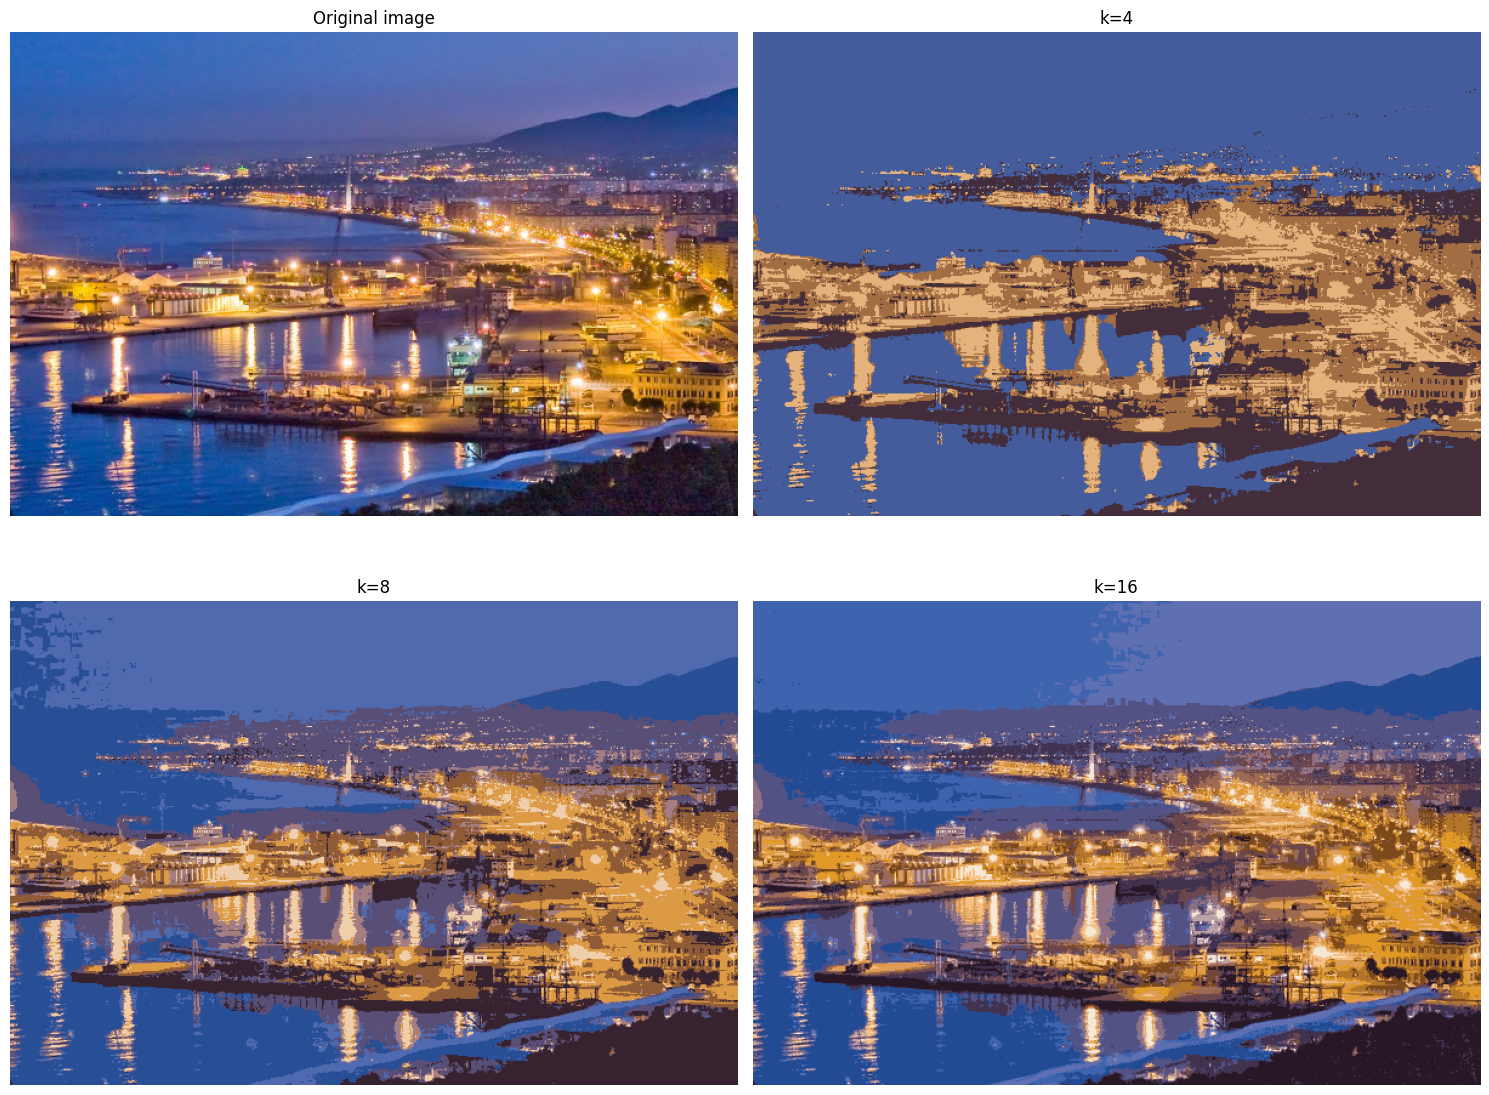

In [28]:
# Problema 5.1
matplotlib.rcParams['figure.figsize'] = (15.0, 12.0)

# Read RGB image
img = cv2.imread('images/malaga.png')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Flatten image
Z = img_rgb.reshape((-1, 3))
Z = np.float32(Z)
# Set criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)

# Apply k-means
K_vals = [4, 8, 16]
results = []

for K in K_vals:
    _, labels, centers = cv2.kmeans(Z, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    # Colour resultant labels
    centers = np.uint8(centers)
    quantized = centers[labels.flatten()]

    # Reshape to original shape
    quantized_img = quantized.reshape((img_rgb.shape))
    results.append(quantized_img)


# Show original image
plt.subplot(2, 2, 1)
plt.imshow(img_rgb)
plt.title("Original image")
plt.axis('off')

# Show k=4
plt.subplot(2, 2, 2)
plt.imshow(results[0])
plt.title("k=4")
plt.axis('off')

# Show k=8
plt.subplot(2, 2, 3)
plt.imshow(results[1])
plt.title("k=8")
plt.axis('off')

# Show k=16
plt.subplot(2, 2, 4)
plt.imshow(results[2])
plt.title("k=16")
plt.axis('off')

plt.tight_layout()
plt.show()

### <font color="blue"><b><i>Thinking about it (1)</i></b></font>

Now, **answer the following questions**:

- What number of maximum iterations did you use? Why?
  
    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Your answer here!</i></p>
    
- How could it be possible to compress these images? *Note: consider that a pixel needs 3 bytes to be represented, 8 bits per band.*
  
    <p style="margin: 4px 0px 0px 5px; color:blue"><i>Your answer here!</i></p>  

### <font color="blue"><b><i>Thinking about it (1)</i></b></font>

Ahora, **responde a las siguientes preguntas**:

- ¬øQu√© n√∫mero de iteraciones m√°ximas utilizaste? ¬øPor qu√©?
  
    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Utilic√© un n√∫mero m√°ximo de 20 iteraciones. Este valor es suficiente porque el algoritmo k-means tiende a converger r√°pidamente, especialmente cuando se trabaja con im√°genes y se fija un criterio de parada adicional con un epsilon peque√±o. De hecho, en la mayor√≠a de ejecuciones la convergencia se alcanza antes de llegar al m√°ximo permitido.</i></p>
    
- ¬øC√≥mo ser√≠a posible comprimir estas im√°genes? *Nota: considera que un p√≠xel necesita 3 bytes para ser representado, 8 bits por banda.*.
  
    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Una forma de comprimir estas im√°genes es aprovechando la reducci√≥n de la paleta de colores. Por ejemplo, si usamos K=16, significa que la imagen solo utiliza 16 colores distintos. En lugar de almacenar 3 bytes por p√≠xel (uno por cada canal RGB), podemos almacenar un √≠ndice de 4 bits por p√≠xel (suficiente para representar 16 valores), y mantener por separado una tabla con los 16 colores (cada uno con 3 bytes). Esto reduce significativamente el tama√±o total de la imagen: pasamos de almacenar 24 bits por p√≠xel a solo 4 bits m√°s una tabla de 48 bytes (16 √ó 3). Este enfoque es similar a t√©cnicas de compresi√≥n como el formato GIF.</i></p>  

###  **<span style="color:green"><b><i>ASIGNACI√ìN EXTRA: Analizar los tiempos de ejecuci√≥ns</i></b></span>**

En este ejercicio se le pide que compare el tiempo de ejecuci√≥n de K-means en una imagen en escala de grises, con K-means en una imagen RGB. Usa la imagen `malaga.png` para esta tarea, y usa el mismo n√∫mero de clusters y criterios para ambas im√°genes, la de escala de grises y la RGB.

*Sugerencia: [c√≥mo medir el tiempo de ejecuci√≥n en Python](https://stackoverflow.com/questions/14452145/how-to-measure-time-taken-between-lines-of-code-in-python)*

In [30]:
import time

print("Measuring the execution time needed for ...")


# Read images
img = cv2.imread('images/malaga.png')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


# Set criteria
K = 8
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 20, 0.2)
cv2.setRNGSeed(124)

# Start timer
start_time_gray = time.time()

# Flatten image
gray_flattened = img_gray.reshape((-1, 1)).astype(np.float32)

# Apply k-means
_, label_gray, center_gray = cv2.kmeans(gray_flattened, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)


# Stop timer
end_time_gray = time.time()
elapsed_gray = end_time_gray - start_time_gray

# Start timer
start_time_rgb = time.time()
# Flatten image
rgb_flattened = img_rgb.reshape((-1, 3)).astype(np.float32)

# Apply k-means
_, label_rgb, center_rgb = cv2.kmeans(rgb_flattened, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

# Stop timer
end_time_rgb = time.time()
elapsed_rgb = end_time_rgb - start_time_rgb

# Show times
print(f"Tiempo en escala de grises: {elapsed_gray:.4f} segundos")
print(f"Tiempo en RGB: {elapsed_rgb:.4f} segundos")

Measuring the execution time needed for ...
Tiempo en escala de grises: 0.6393 segundos
Tiempo en RGB: 0.5555 segundos
